In [1]:
import os
import sys
from datetime import datetime
from pathlib import Path

import numpy as np
import soundfile as sf
from cached_path import cached_path
from hydra.utils import get_class
from omegaconf import OmegaConf
from importlib.resources import files

sys.path.append("/mnt/workspace/zhangjunan/F5-TTS/src/")

from f5_tts.infer.utils_infer import (
    device,
    infer_process,
    load_model,
    load_vocoder,
)

model_name = "F5TTS_v1_Base"
vocoder_name = "vocos"

vocoder = load_vocoder(vocoder_name=vocoder_name, device=device)
model_config_path = str(files("f5_tts").joinpath(f"configs/{model_name}.yaml"))
model_cfg = OmegaConf.load(model_config_path)

repo_name, ckpt_step, ckpt_type = "F5-TTS", 1250000, "safetensors"
checkpoint_path = str(cached_path(f"hf://SWivid/{repo_name}/{model_name}/model_{ckpt_step}.{ckpt_type}"))

model_cls = get_class(f"f5_tts.model.{model_cfg.model.backbone}")
model_arc = model_cfg.model.arch

ema_model = load_model(
    model_cls, 
    model_arc, 
    checkpoint_path, 
    mel_spec_type=vocoder_name, 
    device=device
)

/mnt/workspace/zhangjunan/miniconda3/envs/f5-tts/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Download Vocos from huggingface charactr/vocos-mel-24khz

vocab :  /mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/examples/vocab.txt
token :  custom
model :  /mnt/workspace/zhangjunan/.cache/huggingface/hub/models--SWivid--F5-TTS/snapshots/84e5a410d9cead4de2f847e7c9369a6440bdfaca/F5TTS_v1_Base/model_1250000.safetensors 



torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) tensor(0.2925, device='cuda:0')
DiT InputEmbedding: torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) torch.Size([1, 509, 512])
DiT InputEmbedding: torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) torch.Size([1, 509, 512])
torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) tensor(0.3071, device='cuda:0')
DiT InputEmbedding: torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) torch.Size([1, 509, 512])
DiT InputEmbedding: torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) torch.Size([1, 509, 512])
torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) tensor(0.3213, device='cuda:0')
DiT InputEmbedding: torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) torch.Size([1, 509, 512])
DiT InputEmbedding: torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) torch.Size([1, 509, 512])
torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) tensor(0.3359, device='cuda:0')
DiT InputEmbedding: torch.Size([1, 509, 100]) torch.Size([1, 509, 100]) torc

/mnt/workspace/zhangjunan/miniconda3/envs/f5-tts/lib/python3.11/site-packages/vocos/heads.py:67: UserWarning: ComplexHalf support is experimental and many operators don't support it yet. (Triggered internally at ../aten/src/ATen/EmptyTensor.cpp:44.)
  S = mag * (x + 1j * y)


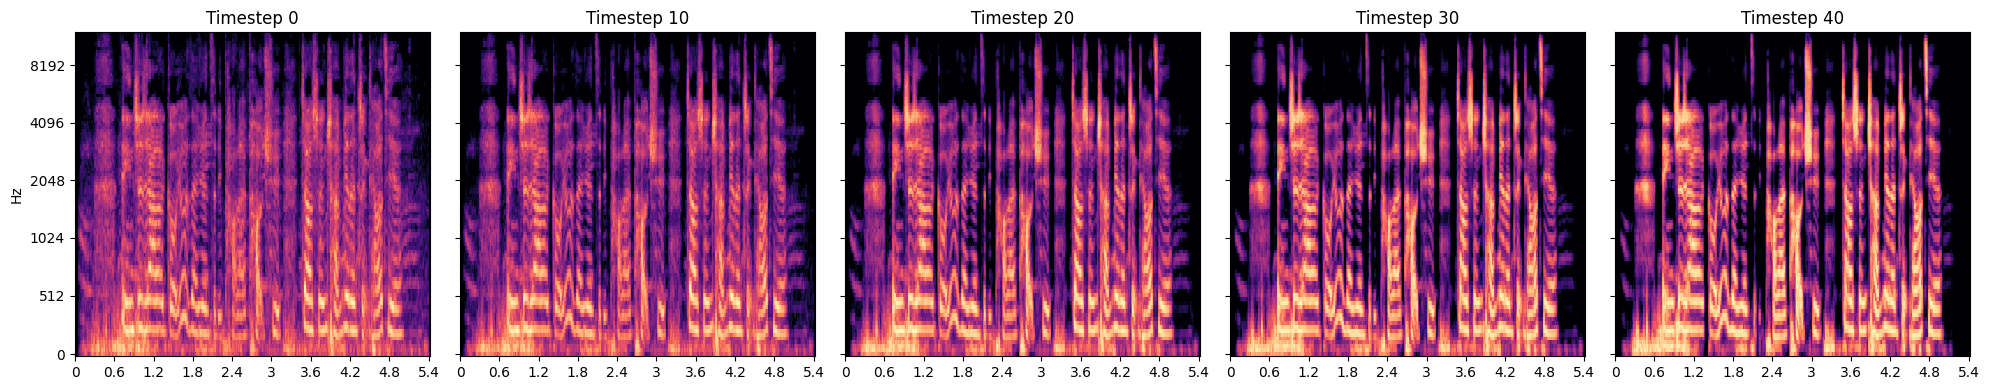

In [ ]:
from random import random
from typing import Callable

import torch
import torchaudio
import torch.nn.functional as F
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torchdiffeq import odeint

from f5_tts.model.modules import MelSpec
from f5_tts.model.utils import (
    default,
    exists,
    get_epss_timesteps,
    lens_to_mask,
    list_str_to_idx,
    list_str_to_tensor,
    mask_from_frac_lengths,
)

import librosa
from matplotlib import pyplot as plt
from IPython.display import Audio, display

%matplotlib inline

sample_rate = 24000

target_sample_rate = 24000
n_mel_channels = 100
hop_length = 256
win_length = 1024
n_fft = 1024
target_rms = 0.1

@torch.no_grad()
# fp16
@torch.autocast(device_type="cuda", dtype=torch.float16)
def sample_denoise(
    self,
    noisy_audio_path,
    cond,
    text,
    # duration,
    vocoder,
    *,
    lens=None,
    steps=32,
    cfg_strength=1.0,
    intermediate_steps_stride=8,
    sway_sampling_coef=-1,
):
    self.eval()

    audio, sr = torchaudio.load(noisy_audio_path)

    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)
    if sr != 24000:
        resampler = torchaudio.transforms.Resample(sr, 24000)
        audio = resampler(audio)
    y_noisy = self.mel_spec(audio.to(self.device)).permute(0, 2, 1)

    if cond.ndim == 2:
        cond = self.mel_spec(cond)
        cond = cond.permute(0, 2, 1)

    cond = cond.to(next(self.parameters()).dtype)
    batch, cond_seq_len, device = *cond.shape[:2], cond.device
    
    if lens is None:
        lens = torch.full((batch,), cond_seq_len, device=device, dtype=torch.long)

    # text = torch.zeros((batch, 1), device=device, dtype=torch.long)
    if isinstance(text, list):
        if exists(self.vocab_char_map):
            text = list_str_to_idx(text, self.vocab_char_map).to(device)
        else:
            text = list_str_to_tensor(text).to(device)
        assert text.shape[0] == batch

    cond_mask = lens_to_mask(lens)

    duration = y_noisy.shape[1]
    if isinstance(duration, int):
        duration = torch.full((batch,), duration, device=device, dtype=torch.long)
    
    max_duration = duration.amax()

    cond = F.pad(cond, (0, 0, 0, max_duration - cond_seq_len), value=0.0)
    cond_mask = F.pad(cond_mask, (0, max_duration - cond_mask.shape[-1]), value=False).unsqueeze(-1)
    step_cond = torch.where(cond_mask, cond, torch.zeros_like(cond))

    def fn(t, x):
        print(x.shape, cond.shape, t)
        pred_cfg = self.transformer(
            x=x,
            cond=step_cond,
            text=text,
            time=t,
            cfg_infer=True,
            cache=True,
        )
        pred, null_pred = torch.chunk(pred_cfg, 2, dim=0)
        return pred + (pred - null_pred) * cfg_strength

    # interpolate noisy mel and random noise
    y0 = y_noisy + 0.4 * torch.randn(batch, max_duration, self.num_channels, device=self.device, dtype=step_cond.dtype)
    # y0 = torch.randn(batch, max_duration, self.num_channels, device=self.device, dtype=step_cond.dtype)
    t = torch.linspace(0.5, 1, steps + 1, device=self.device, dtype=step_cond.dtype)

    if sway_sampling_coef is not None:
        t = t + sway_sampling_coef * (torch.cos(torch.pi / 2 * t) - 1 + t)
    
    trajectory = odeint(fn, y0, t, **self.odeint_kwargs)
    self.transformer.clear_cache()

    intermediate_audios = {}
    
    indices_to_sample = range(0, steps + 1, intermediate_steps_stride)
    print(indices_to_sample)

    for step_index in indices_to_sample:
        # 1. 从轨迹中获取当前时间步的梅尔频谱图
        mel_at_step = trajectory[step_index]

        # 2. 将参考音频部分拼接回去
        out_mel = torch.where(cond_mask, cond, mel_at_step)
        
        # 3. 切片出新生成的部分
        generated_mel = out_mel[:, cond_seq_len:, :]
        
        # 4. 调整维度并用声码器解码
        generated_mel_for_vocoder = generated_mel.permute(0, 2, 1)
        generated_wave = vocoder.decode(generated_mel_for_vocoder.to(torch.float32))
        
        # 5. 转换为Numpy数组并存储
        final_wave_numpy = generated_wave.squeeze().cpu().numpy()
        intermediate_audios[step_index] = final_wave_numpy
        
    return intermediate_audios

def inference_denoise_with_intermediate_steps(
    noisy_audio_path,
    total_duration_frames,
    model_obj,
    vocoder,
    device,
    nfe_step=32,
    cfg_strength=2.0,
    stride=8,
):
    
    # --- 3. 调用新的采样函数 ---
    # 注意：我们将新的采样函数绑定到模型实例上，以便它可以访问 self
    import types
    model_obj.sample_denoise = types.MethodType(sample_denoise, model_obj)
    
    intermediate_audios = model_obj.sample_denoise(
        noisy_audio_path=noisy_audio_path,
        cond=torch.zeros(1, 0, 100).to(device),
        # text=["She can scoop these things into three red bags, and we will go meet her Wednesday at the train station."],
        # text=["邻居家的狗又在院子里跑来跑去，叫声传遍了整条街。"],
        text=[" "],
        # duration=total_duration_frames,
        vocoder=vocoder,
        steps=nfe_step,
        cfg_strength=cfg_strength,
        intermediate_steps_stride=stride,
    )
            
    return intermediate_audios

# --- 5. 运行并展示结果 ---

intermediate_results = inference_denoise_with_intermediate_steps(
    noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/p232_005.wav",
    # noisy_audio_path="/mnt/workspace/zhangjunan/F5-TTS/src/f5_tts/infer/tests/suvi_happy.wav",
    total_duration_frames=700,
    model_obj=ema_model,
    vocoder=vocoder,
    device=device,
    nfe_step=40,
    stride=10
)

# 循环展示每个中间步骤的音频
# for step, audio_data in sorted(intermediate_results.items()):
#     print(f"--- 音频 @ Timestep {step} ---")
#     audio_player = Audio(data=audio_data, rate=target_sample_rate)
#     display(audio_player)
audio_player = Audio(data=intermediate_results[list(intermediate_results.keys())[-1]], rate=24000)
display(audio_player)

torchaudio.save("denoise_out.wav", torch.from_numpy(intermediate_results[list(intermediate_results.keys())[-1]]).unsqueeze(0), 24000)

import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

sorted_items = sorted(intermediate_results.items())
num_plots = len(sorted_items)

fig, axes = plt.subplots(1, num_plots, figsize=(num_plots * 4, 4), sharey=True)
if num_plots == 1:
    axes = [axes]

for i, (step, audio_data) in enumerate(sorted_items):
    mel = librosa.feature.melspectrogram(    
        y=audio_data, 
        sr=24000, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        win_length=win_length, 
        n_mels=n_mel_channels
    )

    mel_db = librosa.power_to_db(mel, ref=np.max)
    
    img = librosa.display.specshow(
        mel_db,
        sr=target_sample_rate,
        hop_length=hop_length,
        x_axis='time',
        y_axis='mel',
        ax=axes[i]
    )
    axes[i].set_title(f'Timestep {step}')
    if i > 0:
        axes[i].set_ylabel(None)
    axes[i].set_xlabel(None)

plt.tight_layout()
plt.show()